<a href="https://colab.research.google.com/github/quillaur/chess_ai_gaming/blob/main/data_science/computer_vision/project_1_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The goal of this project it to identify if a pictures contains an elephant or not. We are thus dealing with a classification problem. It can be viewed in 2 ways: a one class classification or a binary one.

We will first look at the dataset content and describe it. Then, features will be extracted from images and processed into a classifier. Performances will be evaluated using the accuracy.

Since it is imposed on us, we will use sklearn and TF-Hub only to do our analysis and modelisation.

# Module imports

In [32]:
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

# Dataset exploration

## Loading the data

In [8]:
elephants = []
others = []

for root, dirs, files in os.walk("/content/pets"):
  for file in files:
    if file.endswith("jpeg"):
      if "ele" in file:
        elephants.append(os.path.join(root, file))
      else:
        others.append(os.path.join(root, file))

In [9]:
dataset = elephants + others
target = [0]*len(elephants) + [1]*len(others)

## Size visualisation

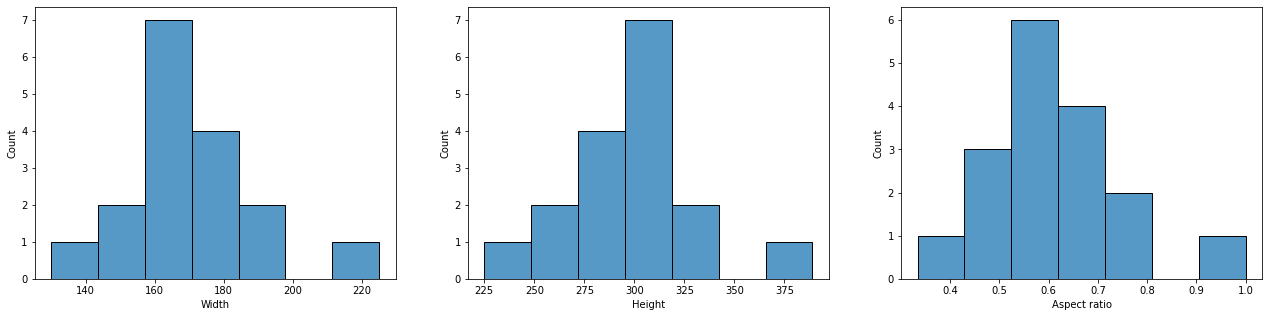

In [22]:
widths = []
heights = []
aspect_ratios = []

for img_path in dataset:
  # Open img as a numpy array.
  img = cv2.imread(img_path)
  # We can get the width (w) and height (h) from the shape of the array.
  w, h, c = img.shape
  widths.append(w)
  heights.append(h)
  aspect_ratios.append(w/h)

vis_df = pd.DataFrame(
  {
    "Width": widths,
    "Height": heights,
    "Aspect ratio": aspect_ratios,
    "Category": target
  }
)

fig, axes = plt.subplots(1, 3, figsize=(22,5))
# sns.scatterplot(data=vis_df, x="Width", y="Height", hue="Category", ax=axes[0])
sns.histplot(data=vis_df, x="Width", ax=axes[0])
sns.histplot(data=vis_df, x="Height", ax=axes[1])
sns.histplot(data=vis_df, x="Aspect ratio", ax=axes[2])

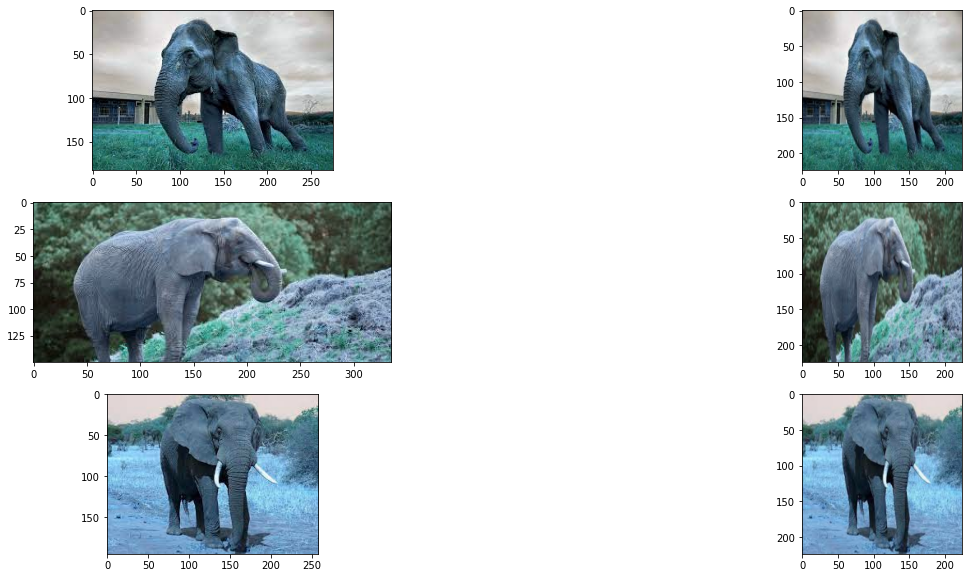

In [26]:
# What happens when I resize pictures ?
pict_numb = 3
resizing = (224,224)

fig, axes = plt.subplots(pict_numb, 2, figsize=(22,10))
for i in range(pict_numb):
  img = cv2.imread(dataset[i])
  img_resized = cv2.resize(img, resizing)
  axes[i,0].imshow(img)
  axes[i,1].imshow(img_resized)

# Preprocessing

In [27]:
def preprocessing(img: np.ndarray, resize: tuple=(224,224), grayscale: bool=True, equal_hist: bool=True) -> np.ndarray:
  img = cv2.resize(img, resizing)

  if grayscale:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  if equal_hist:
    img = cv2.equalizeHist(img)
  
  return img

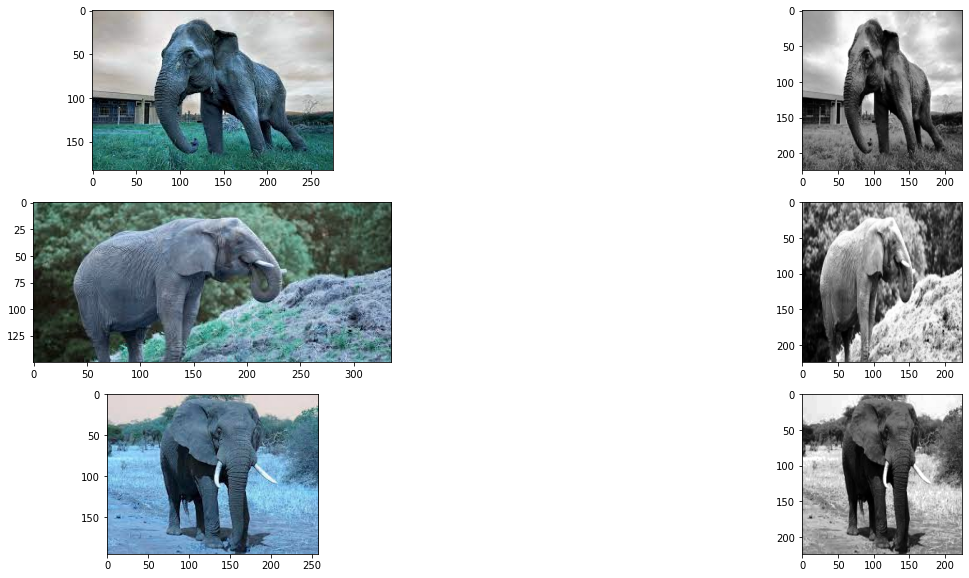

In [30]:
pict_numb = 3
grayscale = True

fig, axes = plt.subplots(pict_numb, 2, figsize=(22,10))
for i in range(pict_numb):
  img = cv2.imread(dataset[i])
  axes[i,0].imshow(img)
  axes[i,1].imshow(preprocessing(img, grayscale=grayscale), cmap="gray" if grayscale else "'viridis'")

In [33]:
preprocessed_data = []
for img_path in tqdm(dataset):
  preprocessed_data.append(preprocessing(cv2.imread(img_path)).flatten())

  0%|          | 0/17 [00:00<?, ?it/s]

# Features Extraction

* https://www.kaggle.com/code/lorinc/feature-extraction-from-images
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.PatchExtractor.html#sklearn.feature_extraction.image.PatchExtractor


# Sklearn modelisation

https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

In [34]:
clf = SVC(gamma=0.001)
cv_results = cross_validate(clf, preprocessed_data, target, cv=3)

In [36]:
pd.DataFrame(cv_results)

,fit_time,score_time,test_score
0,0.051047,0.030553,0.5
1,0.031859,0.023418,0.5
2,0.017257,0.039434,0.4


# Using pretrained-model

https://huggingface.co/tasks/image-classification